In [15]:
import math

def bond_price_dur_conv(C,P,y,mat,coupon_frequency):
    B = 0
    duration_sum = 0
    convexity_sum = 0

    total_payments = coupon_frequency * mat
    for payment in range(1,total_payments+1):
        payment_time = payment/coupon_frequency
        
        B +=  C * math.exp(-y * payment_time)
        duration_sum += C * payment_time* math.exp(-y * payment_time)
        convexity_sum += C * payment_time**2 * math.exp(-y * payment_time)
        
    B += P * math.exp(-y* mat)
    duration_sum += P * mat * math.exp(-y * mat)
    convexity_sum += P * mat**2 * math.exp(-y * mat)
    
    ###convention is to report duration as a positive number
    duration = -(-1/B * duration_sum)
    convexity = 1/B * convexity_sum
    
    return B,duration,convexity

bond_price_dur_conv(0.05*100/2,100,0.05,30,2)

# (10430.589989789156, 4.498366646086723, 21.596380839001984)

(99.03295885512081, 15.772438727763378, 359.73213684991356)

427.4094946894275


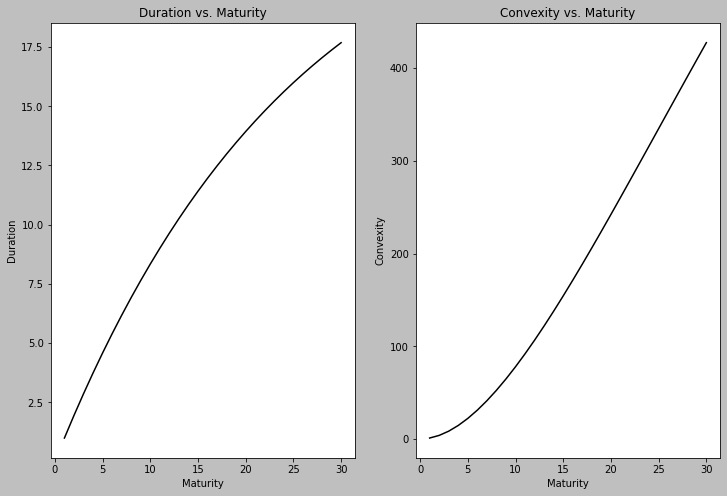

In [102]:
import math
import matplotlib.pyplot as plt

plt.style.use('grayscale')

def bond_price_dur_conv(C,P,y,mat,coupon_frequency):
    
    B = 0
    duration_sum = 0
    convexity_sum = 0

    total_payments = coupon_frequency * mat
    
    for payment in range(1,total_payments+1):
        
        payment_time = payment/coupon_frequency
            
        B +=  C * math.exp(-y * payment_time)
        duration_sum += C * payment_time* math.exp(-y * payment_time)
        convexity_sum += C * payment_time**2 * math.exp(-y * payment_time)
        
          
    B += P * math.exp(-y* mat)
    duration_sum += P * mat * math.exp(-y * mat)
    convexity_sum += P * mat**2 * math.exp(-y * mat)
    
    
    ###convention is to report duration as a positive number
    duration = -(-1/B * duration_sum)
    convexity = 1/B * convexity_sum
    
    return B,duration,convexity

def dur_conv_vs_mat(C,P,y,coupon_frequency,mat_lo,mat_hi):
    
    durations = []
    convexities = []
    maturities = range(mat_lo,mat_hi + 1)
    
    for mat in maturities:
        
        B,duration,convexity = bond_price_dur_conv(C,P,y,mat,coupon_frequency)
 
        durations.append(duration)
        convexities.append(convexity)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))
    ax[0].plot(maturities,durations)
    ax[0].set_xlabel('Maturity')
    ax[0].set_ylabel('Duration')
    ax[0].set_title("Duration vs. Maturity")
    

    ax[1].plot(maturities, convexities)
    ax[1].set_xlabel('Maturity')
    ax[1].set_ylabel('Convexity')
    ax[1].set_title("Convexity vs. Maturity")
    
    plt.savefig('dur_convex_by_mat.png')
    
    print(convexities[-1])
        
    return 


dur_conv_vs_mat(0.04*10000/2,10000,0.04,2,1,30)

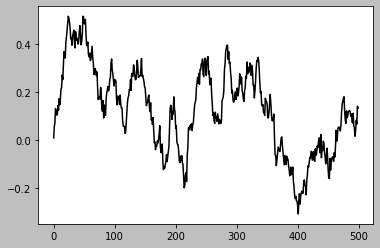

In [24]:
import numpy as np

def sim_HW(r0, kappa, theta0, sigma, T,nper):
    rate_path = np.zeros(T*nper)
    rate_path[0] = r0
    
    dt = 1/nper
    for i in range(1,T*nper):
        theta = theta0 + np.exp(-0.5 * i)
        dWt = np.random.normal(0,np.sqrt(1/nper))
        
        rate_path[i] = rate_path[i-1] + kappa*(theta/kappa - rate_path[i-1]) * dt + sigma * dWt
             
    return rate_path

rate_path = sim_HW(0.01, 0.25, 0.025, 0.25, 10, 50)

plt.plot(rate_path)

In [2]:
import numpy as np
import scipy
from scipy.optimize import minimize

def asymptotic_normal_vol(T,K,F0,sigma0,alpha,beta,rho):
    Fmid = (F0 + K)/2
    zeta = alpha/(sigma0 * (1-beta)) * (F0 ** (1-beta) - K **(1-beta))
    eps = T*alpha**2
    delta = np.log((np.sqrt(1-2 * rho * zeta + zeta**2) + zeta - rho)/(1-rho))
    gamma1 = beta/Fmid
    gamma2 = beta * (beta -1)/Fmid**2
    
    parta = alpha * (F0-K)/delta
    partb1 = (2*gamma2 - gamma1**2)/24 * (sigma0 * Fmid ** beta /alpha)**2
    partb2 = rho * gamma1/4 * sigma0 * Fmid **beta/alpha
    partb3 = (2-3 *rho **2)/24
    partb = (1+(partb1 + partb2 + partb3) * eps)
    
    return parta*partb

def rootfind_helper(sabr_params,T,K_list,F0,sigma_list):
    sigma0,alpha,rho = sabr_params
    beta = 0.5
    MSE = 0
    
    for i in range(len(K_list)):
        diff = asymptotic_normal_vol(T,K_list[i],F0,sigma0,alpha,beta,rho) - sigma_list[i]
        MSE += diff**2
        
    return MSE

def calibrate_sabr(T_list,K_table,F0_list,sigma_table):
    init_guess = [0.1,0.1,-0.1]
    params = np.zeros((len(T_list),3))
    
    for i,T in enumerate(T_list):
        opt = minimize(rootfind_helper,init_guess,args = (T,K_table[i], F0_list[i],sigma_table[i]), method = 'SLSQP', bounds = ((0.01,1.5),(0,10),(-0.98,0.98)))
        params[i] = opt.x
    
    return params

Ts = [1, 2, 3, 5, 7, 10]

Ks = [0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02]
K_list = [Ks, Ks, Ks, Ks, Ks, Ks]

F0s = [0.0135, 0.0142, 0.0146, 0.0149, 0.0153, 0.0158]

sigmas = [0.145, 0.15, 0.155, 0.16, 0.165, 0.17]
sigma_list = [sigmas, sigmas, sigmas, sigmas, sigmas, sigmas]

calibrate_sabr(Ts, K_list, F0s, sigma_list)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


array([[ 0.46388903,  7.23124398, -0.3451205 ],
       [ 0.5916278 ,  2.77038804,  0.98      ],
       [ 0.32866449,  4.70253937, -0.27106614],
       [ 0.28171536,  3.96614421, -0.26097288],
       [ 0.24493138,  3.32019956, -0.18288481],
       [ 0.21654664,  2.80736707, -0.11152624]])

In [58]:
def sabr_normal_vol(S_0,K,T,sigma_0,alpha,beta,rho):
    c = lambda x: x**beta
    c_prime = lambda x: beta*(x**(beta-1))
    c_prime_prime = lambda x: beta*(beta-1)*(x**(beta-2))
    S_mid = (S_0 + K)/2
    gamma_1 = c_prime(S_mid)/c(S_mid)
    gamma_2 = c_prime_prime(S_mid)/c(S_mid)
    zeta = alpha*(S_0**(1-beta) - K**(1-beta))/(sigma_0 * (1-beta))
    epsilon = T*(alpha**2)
    delta = np.log( (np.sqrt(1 - 2*rho*zeta + zeta**2) + zeta - rho)/(1-rho) )

    factor = alpha*(S_0 - K)/(delta)
    term_1 = ((2*gamma_2 - gamma_1**2)/24)* (sigma_0*c(S_mid)  / alpha)**2
    term_2 = rho*gamma_1*sigma_0*c(S_mid)/(4*alpha)
    term_3 = (2-3*(rho**2))/24
    return factor*(1 + epsilon*(term_1 + term_2 + term_3)), term_1, term_2, term_3, epsilon

def asymptotic_normal_vol(T,K,F0,sigma0,alpha,beta,rho):
    Fmid = (F0 + K)/2
    zeta = alpha/(sigma0 * (1-beta)) * (F0 ** (1-beta) - K **(1-beta))
    eps = T*alpha**2
    delta = np.log((np.sqrt(1-2 * rho * zeta + zeta**2) + zeta - rho)/(1-rho))
    gamma1 = beta/Fmid
    gamma2 = beta * (beta -1)/Fmid**2
    
    parta = alpha * (F0-K)/delta
    partb1 = (2*gamma2 - gamma1**2)/24 * (sigma0 * Fmid ** beta /alpha)**2
    partb2 = rho * gamma1/4 * sigma0 * Fmid **beta/alpha
    partb3 = (2-3*rho**2)/24
    partb = (1+(partb1 + partb2 + partb3) * eps)
    
    return parta*partb, partb1, partb2, partb3, eps

F0 = 0.01
K = 0.0105
T = 1.0
sigma_0 = 0.05
alpha = 0.9
beta = 0.6
rho = -0.2

print(sabr_normal_vol(F0, K, T, sigma_0, alpha, beta, rho))
print(asymptotic_normal_vol(T, K, F0, sigma_0, alpha, beta, rho))

(0.0033301919958438216, -0.004216420749024445, -0.010412600435628807, 0.07833333333333332, 0.81)
(0.0033301919958438216, -0.004216420749024448, -0.010412600435628807, 0.07833333333333332, 0.81)


In [99]:
def integral(ssem,tsem,smallf):
    s = 0
    for i in range(tsem-ssem+1):
        s += 0.5 * smallf[ssem+i]           
    return s

def forward(ssem,tsem,smallf):
    integral_part = integral(ssem,tsem,smallf)
    if(ssem == tsem):
        return 0
    
    result = (math.exp(integral_part)-1)*(1/(tsem-ssem))
    return result

def discount(ssem,tsem,smallf):
    integral_part = integral(ssem,tsem,smallf)
    return math.exp(-integral_part)

def price_caplet(sigma,t,K,delta,rate):
    f_0 = forward(t,t+delta,rate)
    
    d1 = (math.log(f_0/K) + 0.5*sigma**2*t)/(sigma * math.sqrt(t))
    d2 = (math.log(f_0/K) - 0.5*sigma**2*t)/(sigma * math.sqrt(t))
    
    cap = delta * discount(0,t+delta, rate) * (f_0 * norm.cdf(d1) - K*norm.cdf(d2))
    
    return cap

def price_cap(sigma,delta,start,length,rate,K):
    cap = 0
    
    for i in range(int(length/delta)):
        t = start+delta*i
        caplet = price_caplet(sigma,t,K,delta,rate)
        cap += caplet
    
    return cap
        
print(price_caplet(0.2, 1, 0.015, 1, rates))
print(price_cap(0.2, 1, 1, 5, rates, 0.01))

0.013067162478741038
0.1001315665234341


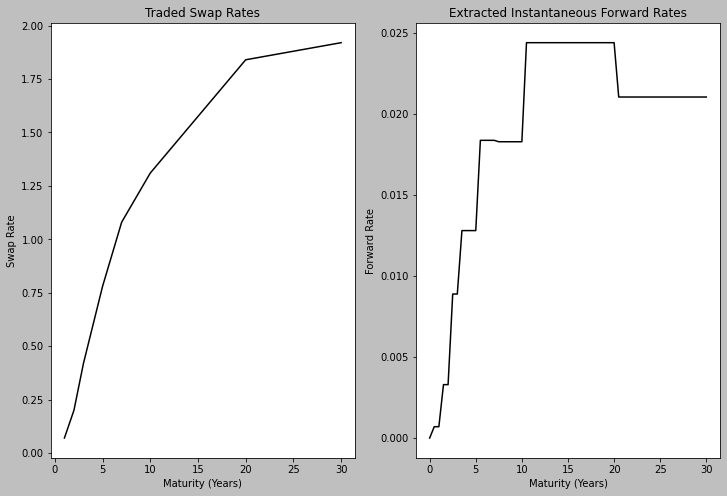

In [23]:
import pandas as pd
import numpy as np
from scipy import optimize
import math
import matplotlib.pyplot as plt

def read_data(rates,mat):
    data = [rates,mat]
    df = pd.DataFrame(data = [rates,mat])
    df = df.transpose()
    df.index = mat
    df.columns = ['Rate', 'Maturity']
    return df

def integral(ssem,tsem,smallf):
    s = 0
    for i in range(tsem-ssem+1):
        s += 0.5 * smallf[ssem+i]           
    return s

def forward(ssem,tsem,smallf):
    integral_part = integral(ssem,tsem,smallf)
    if(ssem == tsem):
        return 0
    
    result = (math.exp(integral_part)-1)*(1/(tsem-ssem))
    return result
    

def discount(ssem,tsem,smallf):
    integral_part = integral(ssem,tsem,smallf)
    return math.exp(-integral_part)


def swaprate(tann,smallf):
    tsem = int(2*tann)
    s_num = 0
    s_denom = 0
    for i in range(1,tsem):
        s_num += discount(0,i,smallf) * forward(i,i+1,smallf)
        s_denom += discount(0,i,smallf)
        
    return s_num/s_denom

def rootfinder(x,tann,smallf,df,prev):
    
    tsem = int(2*tann)
    
    for i in range(1+2*prev,tsem+1):
        smallf[i] = x

    swap = swaprate(tann,smallf)
    return swap - df['Rate'][tann]/100

def main():
    
    rates = [0.07, 0.20, 0.42, 0.78, 1.08, 1.31, 1.84, 1.92]    
    mats = [1,2,3,5,7,10,20, 30]    
    rates = np.array(rates)
    mats = np.array(mats)    
    df = read_data(rates,mats)    
    smallf = np.zeros(61)

    prev = 0    
    for k in mats:
        scipy.optimize.root(rootfinder, 0.01,args = (k,smallf,df,prev))
        prev = k
    
    return rates, mats, smallf                
    
swap_rates, mats, rates = main()
rates

mat_ts = np.arange(0, 61)*0.5

plt.style.use('grayscale')

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Traded Swap Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.plot(mats, swap_rates)

plt.subplot(1, 2, 2)
plt.title("Extracted Instantaneous Forward Rates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Forward Rate")
plt.plot(mat_ts, rates)
plt.savefig('yield_curve.png')

In [15]:
rates

array([0.        , 0.00069976, 0.00069976, 0.00329686, 0.00329686,
       0.00888883, 0.00888883, 0.01943662, 0.01943662, 0.03593306,
       0.03593306, 0.03003108, 0.03003108, 0.03003108, 0.03003108,
       0.02007304, 0.02007304, 0.02007304, 0.02007304, 0.02007304,
       0.02007304,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

In [19]:
mat_dts = np.arange(0, 61)*0.5
mat_dts[21]

10.5

<Figure size 864x576 with 0 Axes>

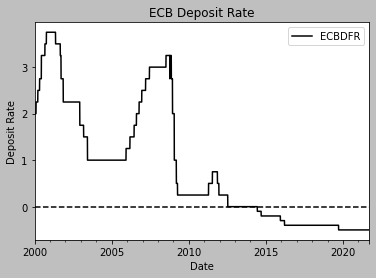

In [42]:
dfECBRates = pd.read_csv('ECBDFR.csv', index_col=0)
dfECBRates.set_index(pd.to_datetime(dfECBRates.index), inplace=True)
                     
plt.figure(figsize=(12, 8))
dfECBRates.plot()
plt.title("ECB Deposit Rate")
plt.xlabel("Date")
plt.ylabel("Deposit Rate")
plt.hlines(0, dfECBRates.index[0], dfECBRates.index[-1], linestyles='dashed')
plt.savefig('ecb_depo_rate_ts.png')
plt.show()

In [41]:
dfECBRates.index

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11',
               '2021-09-12', '2021-09-13', '2021-09-14', '2021-09-15',
               '2021-09-16', '2021-09-17'],
              dtype='datetime64[ns]', name='DATE', length=7931, freq=None)